In [1]:
%matplotlib inline

import numpy as np
import scipy.linalg as la
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

np.set_printoptions(linewidth=130)

In [2]:
from fsmpfuncs import *
from ibmfuncs import *
from gridfuncs import *

In [29]:
from case import *

# if True, starts from an already computed baseflow
# otherwise, the simulation starts from a uniform flow
loadBaseflow = True

min max dy 0.00360217054264 0.00360217054264
min max dx 0.0036 0.0300491341541
x0 -6.56247443811 x1 6.56247443811
y0 -0.46468 y1 0.46468
y1-y0 0.92936


Build matrices (I)

In [6]:
G, DuW, DuE = gradient(dxp, dyp)
R, iR = weight (dx, dy)
Mh, iMh = mass_hat (dx, dy, dxp, dyp)
Lh, Lux0, Lux1, Lvx0, Lvx1, = laplacian_hat(dx, dy, dxp, dyp)
Eh = interpolation_hat(xi, eta, ds, xu, yu, xv, yv, dx, dy, dxp, dyp)
Hh = regularization_hat(xi, eta, ds, xu, yu, xv, yv, dx, dy, dxp, dyp)

E = Eh.dot(iR)
H = Mh.dot(Hh)

L = Mh.dot(Lh.dot(iR))

M = Mh.dot(iR)
iM = R.dot(iMh)

EET = E.dot(E.T)
EH = E.dot(H).tocsc()
iEH = spla.factorized(EH)

iML = iM.dot(L)
Q = sp.hstack([G, E.T])

Build matrices (II)

In [7]:
A = (M/dt - 0.5*iRe*L).tocsc()
B = (M/dt + 0.5*iRe*L).tocsr()

iA = spla.factorized(A)

BN = dt*iM + (0.5*iRe)*dt**2*iML.dot(iM) + (0.5*iRe)**2*dt**3*iML.dot(iML.dot(iM))
QTBNQ = Q.T.dot(BN.dot(Q)).tocsc()
iQTBNQ = spla.factorized(QTBNQ)

In [25]:
if loadBaseflow:
    q = np.loadtxt('0-ComputeBaseflow/baseflow.txt')
    iRq = iR.dot(q)
    u, v = iRq[:n*(m-1)].reshape((n, m-1)), iRq[n*(m-1):].reshape((n, m))    
    nt, ns = 1, 1 # Number of steps and
else:
    u, v = Ux*np.ones(ushape), Ut*np.ones(vshape)
    q = R.dot(np.concatenate([u.ravel(), v.ravel()]))
    nt, ns = int(120/dt) +1, int(1/dt)

# Update boundary conditions
uE, vE = u[:,-1], v[:, -1]

qast = q.copy()

Num1, Nvm1 = advection_hat(dx, dy, dxp, dyp, iR.dot(q), uW, uE, vW, vE)
Nu, Nv = Num1, Nvm1

In [19]:
k = 0
print("Performing", nt, "steps")

t = np.arange(nt)*dt
residuals = np.zeros(nt)
CFx = np.zeros(nt)
CFy = np.zeros(nt)
ψTS = np.zeros(nt)

Performing 1 steps


In [20]:
while k<nt:
    ru = iRe*(Lux0.dot(uW) + Lux1.dot(uE)) - 1.5*Nu + 0.5*Num1
    rv = iRe*(Lvx0.dot(vW) + Lvx1.dot(vE)) - 1.5*Nv + 0.5*Nvm1
    
    bc1 = Mh.dot(np.concatenate([ru, rv]))
    r1 = B.dot(q.ravel()) + bc1

    qast = iA(r1)
    
    bc2 = - (DuW.dot(uW*dy) + DuE.dot(uE*dy))
    r2 = np.concatenate([-bc2, uB, vB])

    λ = iQTBNQ(Q.T.dot(qast) - r2)

    qp1 = qast - BN.dot(Q.dot(λ))
    
    residuals[k] = la.norm(qp1-q)/(dt*la.norm(qp1))
    CFx[k] = 2*np.sum(λ[n*m:n*m+l])
    CFy[k] = 2*np.sum(λ[n*m+l:])
    Δp_ei = np.sum(np.diff(λ[:n*m].reshape((n,m))[:,[0,-3]],axis=1).ravel()*dy)/(y[-1]-y[0])
    ψTS[k] = (Δp_ei - 0.5*Ux**2)/(0.5*Ut**2)
    
    uEm1 = iR.dot(q)[:n*(m-1)].reshape((n, m-1))[:,-1]
    vEm1 = iR.dot(q)[n*(m-1):].reshape((n, m))[:,-1]
    mass = np.sum(uEm1*dy)
    
    if k%1==0:
        print(k, k*dt, residuals[k], CFx[k], CFy[k], ψTS[k])
        
    if k%ns == 0:
        np.savetxt("0-ComputeBaseflow/baseflow.txt", q)
    
    q = qp1
    
    uE = uE - mass/(y[-1]-y[0])*dt/dx[-1]*(uE - uEm1)
    vE = vE - mass/(y[-1]-y[0])*dt/dx[-1]*(vE - vEm1)

    Num1, Nvm1 = Nu, Nv
    Nu, Nv = advection_hat(dx, dy, dxp, dyp, iR.dot(q), uW, uE, vW, vE)
    
    k = k + 1

0 0.0 2.53639431394e-07 -0.13638121497 0.208840218723 0.00329223632114


In [21]:
iRq = iR.dot(q)
u, v = iRq[:n*(m-1)].reshape((n, m-1)), iRq[n*(m-1):].reshape((n, m))
p = λ[:n*m].reshape((n,m))
f = λ[n*m:]

Display solution

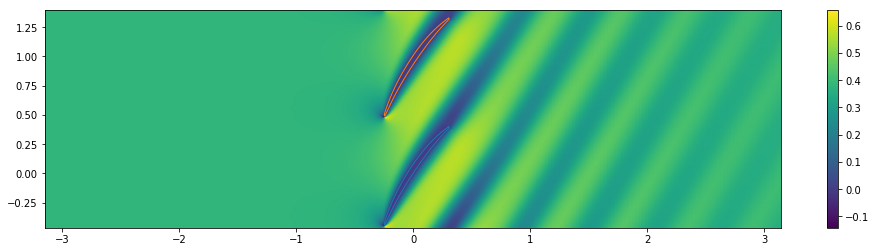

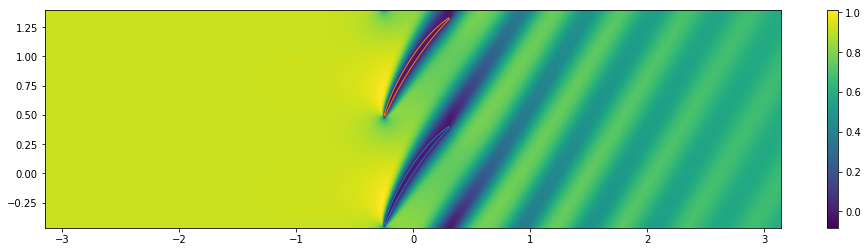

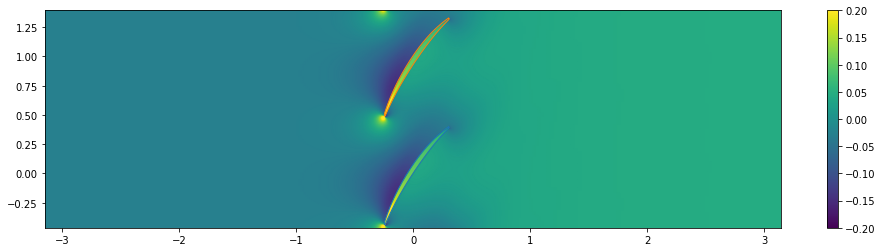

In [22]:
x0, x1 = x[0], x[-1]
y0, y1 = y[0], y[0]+2*(y[-1]-y[0])
x0 = -0.55
x1 = 0.55

plt.figure(figsize=(5.5*3,2*2))
plt.pcolormesh(xu, np.concatenate([yu, yu-y[0]+y[-1]]), np.vstack([u,u]), shading='gouraud')
plt.plot(xi, eta, lw=1)
plt.plot(xi, eta-y[0]+y[-1], lw=1)
plt.axis('equal')
plt.xlim(x0, x1)
plt.ylim(y0, y1)
plt.colorbar()

plt.figure(figsize=(5.5*3,2*2))
plt.pcolormesh(xv, np.concatenate([yv, yv-y[0]+y[-1]]), np.vstack([v,v]), shading='gouraud')
plt.plot(xi, eta, lw=1)
plt.plot(xi, eta-y[0]+y[-1], lw=1)
plt.axis('equal')
plt.xlim(x0, x1)
plt.ylim(y0, y1)
plt.colorbar()

plt.figure(figsize=(5.5*3,2*2))
plt.pcolormesh(xp, np.concatenate([yp, yp-y[0]+y[-1]]), np.vstack([p,p])-np.mean(p), vmin=-0.2, vmax=0.2, shading='gouraud')
plt.plot(xi, eta, lw=1)
plt.plot(xi, eta-y[0]+y[-1], lw=1)
plt.axis('equal')
plt.xlim(x0, x1)
plt.ylim(y0, y1)
plt.colorbar()

/home/miguel/Programs/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:2918: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0.0
  'left=%s, right=%s') % (left, right))


(-0.06, 0)

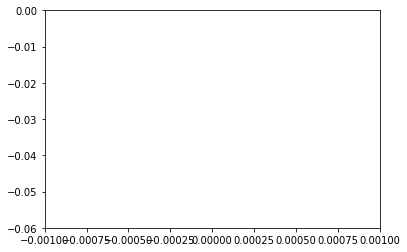

In [23]:
plt.plot(dt*np.arange(len(residuals)), ψTS)
plt.xlim(0,(k-1)*dt)
plt.ylim(-0.06,0)

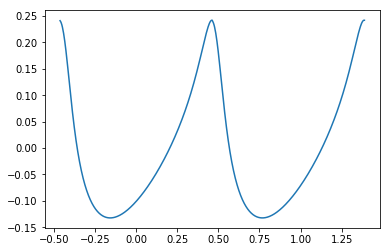

In [26]:
plt.plot(np.concatenate([yp,yp[1:]+yp[-1]-yp[0]]), (np.concatenate([p[:,294],p[1:,294]])-p[0,0])/(0.5*Ut**2))